# Session Data Processing Pipeline

This notebook provides a complete pipeline for:
1. **Downloading** multi-exchange MBP-1 data from Databento
2. **Resampling** to NBBO at fixed intervals with exchange snapshots
3. **Compressing** to binary format for efficient storage
4. **Quality Control** to verify data integrity

Use this notebook to process individual trading sessions interactively.

## Setup and Configuration

In [1]:
import os
import sys
import gzip
import struct
import shutil
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import pandas as pd
import numpy as np
import databento as db
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print("✅ Imports successful")

✅ Imports successful


In [2]:
# Configuration
class Config:
    """Pipeline configuration."""
    
    # Databento API
    DATABENTO_API_KEY = os.environ.get('DATABENTO_API_KEY')
    
    # Multi-exchange datasets
    DATABENTO_DATASETS_MBP1 = [
        'XNAS.ITCH',     # NASDAQ
        'XNYS.PILLAR',   # NYSE
        'IEXG.TOPS',     # IEX
        'ARCX.PILLAR',   # NYSE Arca
        'BATS.PITCH',    # Cboe BZX
        'XBOS.ITCH',     # NASDAQ BX
        'XPSX.ITCH',     # NASDAQ PSX
    ]
    
    # Publisher ID mapping (Databento standard IDs)
    DATASET_TO_PUBLISHER_ID = {
        'XNAS.ITCH': 1,    # NASDAQ
        'XNYS.PILLAR': 2,  # NYSE
        'ARCX.PILLAR': 3,  # NYSE Arca
        'BATS.PITCH': 4,   # Cboe BZX
        'IEXG.TOPS': 5,    # IEX
        'XBOS.ITCH': 6,    # NASDAQ BX
        'BATY.PITCH': 9,   # Cboe BYX
        'EDGA.PITCH': 38,  # Cboe EDGA
        'XPSX.ITCH': 43,   # NASDAQ PSX
    }
    
    # Binary format constants
    BINARY_MAGIC = b'TICK'
    BINARY_VERSION_V3 = 3
    PRICE_SCALE = 100_000
    SIZE_SCALE = 100
    TIME_UNIT = 1_000_000
    GZIP_LEVEL = 9
    
    # NBBO resampling interval (milliseconds)
    NBBO_RESAMPLE_INTERVAL_MS = 100
    
    # Directories
    BASE_DIR = Path('../')
    TEMP_DIR = BASE_DIR / '.notebook_temp'
    SESSIONS_DIR = BASE_DIR / 'sessions'

# Validate API key
if not Config.DATABENTO_API_KEY:
    print("⚠️  WARNING: DATABENTO_API_KEY not set in environment")
    print("   Set it with: os.environ['DATABENTO_API_KEY'] = 'your-key'")
else:
    print("✅ Databento API key found")

# Create directories
Config.TEMP_DIR.mkdir(parents=True, exist_ok=True)
Config.SESSIONS_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Directories ready")

✅ Databento API key found
✅ Directories ready


## 1. Data Fetcher (Multi-Exchange MBP-1)

In [3]:
class DatabentoFetcher:
    """Fetches multi-exchange MBP-1 data from Databento."""
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.client = db.Historical(api_key)
        print("✅ Databento client initialized")
    
    def fetch_mbp1_multi_exchange(
        self,
        symbol: str,
        start_date: datetime,
        end_date: datetime
    ) -> pd.DataFrame:
        """Fetch MBP-1 data from multiple exchanges."""
        print(f"\n{'='*80}")
        print("FETCHING MULTI-EXCHANGE MBP-1 DATA")
        print(f"{'='*80}")
        print(f"Symbol: {symbol}")
        print(f"Start: {start_date}")
        print(f"End: {end_date}")
        print(f"Exchanges: {len(Config.DATABENTO_DATASETS_MBP1)}")
        
        all_data = []
        
        for i, dataset in enumerate(Config.DATABENTO_DATASETS_MBP1, 1):
            print(f"\n[{i}/{len(Config.DATABENTO_DATASETS_MBP1)}] Querying {dataset}...")
            
            try:
                data = self.client.timeseries.get_range(
                    dataset=dataset,
                    symbols=[symbol],
                    schema='mbp-1',
                    start=start_date.isoformat(),
                    end=end_date.isoformat(),
                    stype_in='raw_symbol',
                )
                
                df = data.to_df()
                
                if df.empty:
                    print(f"  ⚠️  No data from {dataset}")
                    continue
                
                print(f"  ✅ {len(df):,} quotes from {dataset}")
                
                # Remap publisher IDs to standard Databento IDs
                if dataset in Config.DATASET_TO_PUBLISHER_ID:
                    correct_pub_id = Config.DATASET_TO_PUBLISHER_ID[dataset]
                    df['publisher_id'] = correct_pub_id
                    print(f"  📍 Publisher ID: {correct_pub_id}")
                
                all_data.append(df)
                
            except Exception as e:
                print(f"  ❌ Error fetching from {dataset}: {e}")
                continue
        
        if not all_data:
            raise ValueError("No data retrieved from any exchange")
        
        # Combine and sort
        print(f"\n{'='*80}")
        print("COMBINING DATA")
        print(f"{'='*80}")
        
        df_combined = pd.concat(all_data, ignore_index=True)
        df_combined = df_combined.sort_values('ts_event').reset_index(drop=True)
        
        print(f"Total quotes: {len(df_combined):,}")
        
        if 'publisher_id' in df_combined.columns:
            exchange_counts = df_combined['publisher_id'].value_counts().to_dict()
            print("\nQuotes per exchange:")
            for pub_id, count in sorted(exchange_counts.items()):
                print(f"  Publisher {pub_id}: {count:,}")
        
        return df_combined

## 2. NBBO Resampler

In [4]:
class NBBOResampler:
    """Resamples multi-exchange tick data to NBBO at fixed intervals."""
    
    def __init__(self, interval_ms: int = None):
        self.interval_ms = interval_ms or Config.NBBO_RESAMPLE_INTERVAL_MS
        print(f"✅ NBBO Resampler initialized (interval: {self.interval_ms}ms)")
    
    def resample(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Resample MBP-1 data to NBBO with exchange snapshots."""
        print(f"\n{'='*80}")
        print("RESAMPLING TO NBBO")
        print(f"{'='*80}")
        
        if df.empty:
            raise ValueError("Empty DataFrame")
        
        # Ensure timestamp column is datetime
        if not pd.api.types.is_datetime64_any_dtype(df['ts_event']):
            df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True)
        else:
            df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True)
        
        df = df.sort_values('ts_event').reset_index(drop=True)
        
        publishers = sorted(df['publisher_id'].unique())
        publisher_map = {pub_id: idx for idx, pub_id in enumerate(publishers)}
        
        original_tick_count = len(df)
        print(f"Publishers: {publishers}")
        print(f"Original ticks: {original_tick_count:,}")
        
        start_time = df['ts_event'].iloc[0]
        end_time = df['ts_event'].iloc[-1]
        
        # Create time bins
        bins = pd.date_range(
            start=start_time.floor(f'{self.interval_ms}ms'),
            end=end_time.ceil(f'{self.interval_ms}ms'),
            freq=f'{self.interval_ms}ms'
        )
        
        print(f"Time range: {start_time} to {end_time}")
        print(f"Resampling bins: {len(bins):,}")
        
        # Assign each tick to a time bin
        df['time_bin'] = pd.cut(df['ts_event'], bins=bins, labels=False, include_lowest=True)
        df = df[df['time_bin'].notna()].copy()
        
        if df.empty:
            raise ValueError("No data in time bins")
        
        # Aggregate by bin and publisher (last quote in each bin)
        grouped = df.groupby(['time_bin', 'publisher_id']).last()
        grouped['bid'] = grouped['bid_px_00']
        grouped['ask'] = grouped['ask_px_00']
        grouped['bid_size'] = grouped['bid_sz_00']
        grouped['ask_size'] = grouped['ask_sz_00']
        grouped = grouped[(grouped['bid'] > 0) & (grouped['ask'] > 0)]
        
        # Pivot to wide format (time_bin x publisher_id)
        ex_wide = grouped.pivot_table(
            index='time_bin',
            columns='publisher_id',
            values=['bid', 'ask', 'bid_size', 'ask_size'],
            aggfunc='last'
        ).sort_index()
        
        # Reindex to all bins and forward-fill (stateful)
        all_bins = range(int(df['time_bin'].min()), int(df['time_bin'].max()) + 1)
        ex_wide = ex_wide.reindex(all_bins).ffill()
        
        # Calculate NBBO from exchange state
        bid_matrix = ex_wide['bid']
        ask_matrix = ex_wide['ask']
        bid_size_matrix = ex_wide['bid_size']
        ask_size_matrix = ex_wide['ask_size']
        
        # Best bid (highest) and best ask (lowest)
        nbbo_bid = bid_matrix.max(axis=1, skipna=True)
        nbbo_bid_pub = bid_matrix.idxmax(axis=1, skipna=True)
        nbbo_ask = ask_matrix.min(axis=1, skipna=True)
        nbbo_ask_pub = ask_matrix.idxmin(axis=1, skipna=True)
        
        # Get sizes for best bid/ask
        nbbo_bid_size = pd.Series([
            bid_size_matrix.loc[idx, pub] if pd.notna(pub) else 0
            for idx, pub in zip(bid_size_matrix.index, nbbo_bid_pub)
        ], index=bid_size_matrix.index)
        
        nbbo_ask_size = pd.Series([
            ask_size_matrix.loc[idx, pub] if pd.notna(pub) else 0
            for idx, pub in zip(ask_size_matrix.index, nbbo_ask_pub)
        ], index=ask_size_matrix.index)
        
        # Create NBBO DataFrame
        nbbo = pd.DataFrame({
            'time_bin': ex_wide.index,
            'nbbo_bid': nbbo_bid,
            'nbbo_bid_size': nbbo_bid_size,
            'nbbo_bid_publisher': nbbo_bid_pub,
            'nbbo_ask': nbbo_ask,
            'nbbo_ask_size': nbbo_ask_size,
            'nbbo_ask_publisher': nbbo_ask_pub,
        })
        nbbo['timestamp'] = bins[nbbo['time_bin'].astype(int)]
        
        # Add exchange snapshots
        exchange_data = ex_wide.copy()
        exchange_data.columns = [f'ex_{col[1]}_{col[0]}' for col in exchange_data.columns]
        
        resampled_df = nbbo.join(exchange_data).reset_index(drop=True)
        
        # Select columns
        nbbo_cols = ['timestamp', 'nbbo_bid', 'nbbo_ask', 'nbbo_bid_size', 'nbbo_ask_size',
                     'nbbo_bid_publisher', 'nbbo_ask_publisher']
        exchange_cols = [col for col in resampled_df.columns if col.startswith('ex_')]
        resampled_df = resampled_df[nbbo_cols + exchange_cols]
        
        print(f"Resampled ticks: {len(resampled_df):,}")
        print(f"Reduction: {100 * (1 - len(resampled_df) / original_tick_count):.1f}%")
        
        metadata = {
            'original_ticks': original_tick_count,
            'resampled_ticks': len(resampled_df),
            'reduction_pct': 100 * (1 - len(resampled_df) / original_tick_count),
            'interval_ms': self.interval_ms,
            'publishers': publishers,
            'publisher_map': publisher_map,
            'start_time': start_time.isoformat(),
            'end_time': end_time.isoformat()
        }
        
        return resampled_df, metadata

## 3. Binary Compressor

In [5]:
class NBBOBinaryCompressor:
    """Compresses NBBO data to custom binary format (Version 3)."""
    
    def __init__(self):
        self.price_scale = Config.PRICE_SCALE
        self.size_scale = Config.SIZE_SCALE
        self.time_unit = Config.TIME_UNIT
        print("✅ Binary compressor initialized")
    
    def compress(
        self,
        df: pd.DataFrame,
        publisher_map: dict,
        output_file: Path
    ) -> Dict:
        """Compress NBBO DataFrame to binary format."""
        print(f"\n{'='*80}")
        print("COMPRESSING TO BINARY FORMAT")
        print(f"{'='*80}")
        
        if df.empty:
            raise ValueError("Empty DataFrame")
        
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Get initial timestamp
        t0 = df['timestamp'].iloc[0]
        initial_timestamp_us = int(t0.timestamp() * self.time_unit)
        
        # Create publisher map string
        publisher_map_str = ','.join([f"{idx}:{pub_id}" for pub_id, idx in publisher_map.items()])
        publisher_map_bytes = publisher_map_str.encode('utf-8')
        
        publisher_id_to_idx = {pub_id: idx for pub_id, idx in publisher_map.items()}
        
        num_samples = len(df)
        buffer = bytearray()
        
        # Write header (4s + H + H + I + Q = 20 bytes)
        header = struct.pack(
            '<4sHHIQ',
            Config.BINARY_MAGIC,
            Config.BINARY_VERSION_V3,
            Config.NBBO_RESAMPLE_INTERVAL_MS,
            num_samples,
            initial_timestamp_us
        )
        buffer.extend(header)
        
        # Write publisher map
        buffer.extend(struct.pack('<H', len(publisher_map_bytes)))
        buffer.extend(publisher_map_bytes)
        
        prev_timestamp_ms = int(t0.timestamp() * 1000)
        
        # Write samples
        for i in range(num_samples):
            row = df.iloc[i]
            
            # Calculate time delta
            current_timestamp_ms = int(row['timestamp'].timestamp() * 1000)
            time_delta_ms = current_timestamp_ms - prev_timestamp_ms
            prev_timestamp_ms = current_timestamp_ms
            
            # Scale NBBO data
            nbbo_bid = int(row['nbbo_bid'] * self.price_scale)
            nbbo_ask = int(row['nbbo_ask'] * self.price_scale)
            nbbo_bid_size = int(row['nbbo_bid_size'] * self.size_scale)
            nbbo_ask_size = int(row['nbbo_ask_size'] * self.size_scale)
            best_bid_pub = publisher_id_to_idx.get(row['nbbo_bid_publisher'], 0)
            best_ask_pub = publisher_id_to_idx.get(row['nbbo_ask_publisher'], 0)
            
            # Write NBBO data (i + i + i + i + i + B + B = 22 bytes)
            nbbo_data = struct.pack(
                '<iiiiiBB',
                time_delta_ms,
                nbbo_bid,
                nbbo_ask,
                nbbo_bid_size,
                nbbo_ask_size,
                best_bid_pub,
                best_ask_pub
            )
            buffer.extend(nbbo_data)
            
            # Write exchange data
            exchanges_data = []
            for pub_id, pub_idx in publisher_map.items():
                bid_col = f'ex_{pub_id}_bid'
                ask_col = f'ex_{pub_id}_ask'
                bid_size_col = f'ex_{pub_id}_bid_size'
                ask_size_col = f'ex_{pub_id}_ask_size'
                
                if bid_col in row.index and not pd.isna(row[bid_col]):
                    bid = int(row[bid_col] * self.price_scale)
                    ask = int(row[ask_col] * self.price_scale)
                    bid_size = int(row[bid_size_col] * self.size_scale)
                    ask_size = int(row[ask_size_col] * self.size_scale)
                    
                    exchanges_data.append((pub_idx, bid, ask, bid_size, ask_size))
            
            # Write number of exchanges (B = 1 byte)
            buffer.extend(struct.pack('<B', len(exchanges_data)))
            
            # Write each exchange (B + i + i + I + I = 17 bytes per exchange)
            for pub_idx, bid, ask, bid_size, ask_size in exchanges_data:
                exchange_data = struct.pack(
                    '<BiiII',
                    pub_idx,
                    bid,
                    ask,
                    bid_size,
                    ask_size
                )
                buffer.extend(exchange_data)
        
        # Compress
        compressed = gzip.compress(bytes(buffer), compresslevel=Config.GZIP_LEVEL)
        
        # Write to file
        output_file.parent.mkdir(parents=True, exist_ok=True)
        with open(output_file, 'wb') as f:
            f.write(compressed)
        
        stats = {
            'output_file': str(output_file),
            'num_samples': num_samples,
            'original_size_mb': len(buffer) / (1024 * 1024),
            'compressed_size_mb': len(compressed) / (1024 * 1024),
            'compression_ratio': len(buffer) / len(compressed),
            'compression_pct': (len(compressed) / len(buffer)) * 100
        }
        
        print(f"Output: {output_file}")
        print(f"Samples: {stats['num_samples']:,}")
        print(f"Original size: {stats['original_size_mb']:.2f} MB")
        print(f"Compressed size: {stats['compressed_size_mb']:.2f} MB")
        print(f"Compression ratio: {stats['compression_ratio']:.2f}x")
        print(f"Space saved: {100 - stats['compression_pct']:.1f}%")
        
        return stats

## 4. Quality Control

In [6]:
class DataQualityChecker:
    """Performs data quality checks on NBBO data."""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.issues = []
        print("✅ Quality checker initialized")
    
    def check_all(self, max_spread_pct: float = 2.0) -> Dict:
        """Run all quality checks."""
        print(f"\n{'='*80}")
        print("DATA QUALITY CHECKS")
        print(f"{'='*80}")
        
        results = {}
        
        # Calculate derived fields
        self.df['spread'] = self.df['nbbo_ask'] - self.df['nbbo_bid']
        self.df['spread_pct'] = (self.df['spread'] / self.df['nbbo_bid']) * 100
        self.df['mid_price'] = (self.df['nbbo_bid'] + self.df['nbbo_ask']) / 2
        
        # 1. Spread checks
        print("\n1. SPREAD CHECKS")
        negative_spreads = len(self.df[self.df['spread'] < 0])
        zero_spreads = len(self.df[self.df['spread'] == 0])
        wide_spreads = len(self.df[self.df['spread_pct'] > max_spread_pct])
        
        print(f"   Negative spreads: {negative_spreads}")
        print(f"   Zero spreads: {zero_spreads}")
        print(f"   Wide spreads (>{max_spread_pct}%): {wide_spreads}")
        print(f"   Mean spread: ${self.df['spread'].mean():.4f} ({self.df['spread_pct'].mean():.4f}%)")
        print(f"   Median spread: ${self.df['spread'].median():.4f}")
        
        if negative_spreads > 0:
            self.issues.append(f"Negative spreads: {negative_spreads}")
            print(f"   ❌ FAIL: Found {negative_spreads} negative spreads")
        else:
            print("   ✅ PASS: No negative spreads")
        
        results['spread'] = {
            'negative': negative_spreads,
            'zero': zero_spreads,
            'wide': wide_spreads,
            'mean': self.df['spread'].mean(),
            'median': self.df['spread'].median()
        }
        
        # 2. Size checks
        print("\n2. SIZE CHECKS")
        zero_bid_size = len(self.df[self.df['nbbo_bid_size'] == 0])
        zero_ask_size = len(self.df[self.df['nbbo_ask_size'] == 0])
        negative_bid_size = len(self.df[self.df['nbbo_bid_size'] < 0])
        negative_ask_size = len(self.df[self.df['nbbo_ask_size'] < 0])
        
        print(f"   Zero bid sizes: {zero_bid_size}")
        print(f"   Zero ask sizes: {zero_ask_size}")
        print(f"   Negative bid sizes: {negative_bid_size}")
        print(f"   Negative ask sizes: {negative_ask_size}")
        print(f"   Mean bid size: {self.df['nbbo_bid_size'].mean():.2f}")
        print(f"   Mean ask size: {self.df['nbbo_ask_size'].mean():.2f}")
        
        if negative_bid_size > 0 or negative_ask_size > 0:
            self.issues.append(f"Negative sizes: bid={negative_bid_size}, ask={negative_ask_size}")
            print(f"   ❌ FAIL: Found negative sizes")
        else:
            print("   ✅ PASS: No negative sizes")
        
        results['size'] = {
            'zero_bid': zero_bid_size,
            'zero_ask': zero_ask_size,
            'negative_bid': negative_bid_size,
            'negative_ask': negative_ask_size
        }
        
        # 3. Price checks
        print("\n3. PRICE CHECKS")
        zero_bid = len(self.df[self.df['nbbo_bid'] <= 0])
        zero_ask = len(self.df[self.df['nbbo_ask'] <= 0])
        
        print(f"   Zero/negative bid: {zero_bid}")
        print(f"   Zero/negative ask: {zero_ask}")
        print(f"   Price range: ${self.df['nbbo_bid'].min():.2f} - ${self.df['nbbo_ask'].max():.2f}")
        print(f"   Mean mid price: ${self.df['mid_price'].mean():.2f}")
        
        if zero_bid > 0 or zero_ask > 0:
            self.issues.append(f"Zero prices: bid={zero_bid}, ask={zero_ask}")
            print(f"   ❌ FAIL: Found zero/negative prices")
        else:
            print("   ✅ PASS: All prices valid")
        
        results['price'] = {
            'zero_bid': zero_bid,
            'zero_ask': zero_ask,
            'min': self.df['nbbo_bid'].min(),
            'max': self.df['nbbo_ask'].max(),
            'mean': self.df['mid_price'].mean()
        }
        
        # 4. Timestamp checks
        print("\n4. TIMESTAMP CHECKS")
        self.df['time_delta'] = self.df['timestamp'].diff()
        self.df['time_delta_ms'] = self.df['time_delta'].dt.total_seconds() * 1000
        
        duplicates = len(self.df[self.df['time_delta_ms'] == 0])
        backwards = len(self.df[self.df['time_delta_ms'] < 0])
        
        print(f"   Duplicate timestamps: {duplicates}")
        print(f"   Backwards timestamps: {backwards}")
        print(f"   Time range: {self.df['timestamp'].iloc[0]} to {self.df['timestamp'].iloc[-1]}")
        print(f"   Duration: {self.df['timestamp'].iloc[-1] - self.df['timestamp'].iloc[0]}")
        
        if backwards > 0:
            self.issues.append(f"Backwards timestamps: {backwards}")
            print(f"   ❌ FAIL: Found backwards timestamps")
        else:
            print("   ✅ PASS: Timestamps monotonic")
        
        results['timestamp'] = {
            'duplicates': duplicates,
            'backwards': backwards,
            'start': self.df['timestamp'].iloc[0],
            'end': self.df['timestamp'].iloc[-1]
        }
        
        # Summary
        print(f"\n{'='*80}")
        print("SUMMARY")
        print(f"{'='*80}")
        
        if len(self.issues) == 0:
            print("\n✅ ALL CHECKS PASSED - Data quality is excellent!")
        else:
            print(f"\n❌ {len(self.issues)} ISSUE(S) DETECTED:")
            for i, issue in enumerate(self.issues, 1):
                print(f"   {i}. {issue}")
        
        results['issues'] = self.issues
        return results
    
    def plot_analysis(self):
        """Create quality analysis plots."""
        print(f"\n{'='*80}")
        print("GENERATING PLOTS")
        print(f"{'='*80}")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('NBBO Data Quality Analysis', fontsize=16, fontweight='bold')
        
        # 1. Price and spread over time
        ax1 = axes[0, 0]
        ax1.plot(self.df['timestamp'], self.df['mid_price'], label='Mid Price', alpha=0.7)
        ax1.fill_between(self.df['timestamp'], self.df['nbbo_bid'], self.df['nbbo_ask'], 
                         alpha=0.3, label='Spread')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price ($)')
        ax1.set_title('Price and Spread Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Spread distribution
        ax2 = axes[0, 1]
        ax2.hist(self.df['spread'], bins=50, edgecolor='black', alpha=0.7)
        ax2.axvline(self.df['spread'].mean(), color='r', linestyle='--', 
                   label=f'Mean: ${self.df["spread"].mean():.4f}')
        ax2.set_xlabel('Spread ($)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Spread Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Spread percentage over time
        ax3 = axes[1, 0]
        ax3.plot(self.df['timestamp'], self.df['spread_pct'], alpha=0.7)
        ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='0.5% threshold')
        ax3.axhline(2.0, color='red', linestyle='--', alpha=0.5, label='2.0% threshold')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Spread (%)')
        ax3.set_title('Spread Percentage Over Time')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Size distribution
        ax4 = axes[1, 1]
        ax4.hist(self.df['nbbo_bid_size'], bins=50, alpha=0.5, 
                label='Bid Size', edgecolor='black')
        ax4.hist(self.df['nbbo_ask_size'], bins=50, alpha=0.5, 
                label='Ask Size', edgecolor='black')
        ax4.set_xlabel('Size (shares)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Bid/Ask Size Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Plots generated")

## 5. Complete Pipeline Function

In [7]:
def process_session(
    symbol: str,
    start_date: datetime,
    end_date: datetime,
    api_key: str = None,
    run_quality_checks: bool = True,
    show_plots: bool = True
) -> Tuple[Path, Dict]:
    """
    Complete pipeline: Download -> Resample -> Compress -> Quality Check
    
    Args:
        symbol: Stock symbol (e.g., 'AAPL')
        start_date: Start datetime
        end_date: End datetime
        api_key: Databento API key (uses env var if None)
        run_quality_checks: Whether to run quality checks
        show_plots: Whether to show plots
    
    Returns:
        Tuple of (output_file_path, metadata_dict)
    """
    print(f"\n{'='*80}")
    print(f"PROCESSING SESSION: {symbol}")
    print(f"{'='*80}")
    print(f"Start: {start_date}")
    print(f"End: {end_date}")
    
    # Initialize components
    api_key = api_key or Config.DATABENTO_API_KEY
    if not api_key:
        raise ValueError("DATABENTO_API_KEY not set")
    
    fetcher = DatabentoFetcher(api_key)
    resampler = NBBOResampler()
    compressor = NBBOBinaryCompressor()
    
    # Step 1: Fetch MBP-1 data
    df_mbp1 = fetcher.fetch_mbp1_multi_exchange(symbol, start_date, end_date)
    
    # Step 2: Resample to NBBO
    df_nbbo, metadata = resampler.resample(df_mbp1)
    
    # Step 3: Compress to binary
    date_str = start_date.strftime('%Y%m%d')
    output_file = Config.SESSIONS_DIR / f"{symbol}-{date_str}.bin.gz"
    compression_stats = compressor.compress(df_nbbo, metadata['publisher_map'], output_file)
    
    # Step 4: Quality checks (optional)
    if run_quality_checks:
        checker = DataQualityChecker(df_nbbo)
        quality_results = checker.check_all()
        
        if show_plots:
            checker.plot_analysis()
        
        metadata['quality_results'] = quality_results
    
    # Combine metadata
    metadata.update(compression_stats)
    
    print(f"\n{'='*80}")
    print("PIPELINE COMPLETE")
    print(f"{'='*80}")
    print(f"✅ Output file: {output_file}")
    print(f"✅ File size: {compression_stats['compressed_size_mb']:.2f} MB")
    print(f"✅ Samples: {compression_stats['num_samples']:,}")
    
    if run_quality_checks and len(quality_results['issues']) == 0:
        print(f"✅ Quality: PASSED")
    elif run_quality_checks:
        print(f"⚠️  Quality: {len(quality_results['issues'])} issues detected")
    
    return output_file, metadata

## 6. Example Usage

Run the complete pipeline for a single session.

In [8]:
# Configure your session
SYMBOL = 'AMIX'  # Change to your desired symbol
DATE = '2025-11-17'  # Change to your desired date
START_TIME = '13:03:00'  # Market open
END_TIME = '15:15:00'    # Market close

# Parse dates
start_dt = datetime.strptime(f"{DATE} {START_TIME}", '%Y-%m-%d %H:%M:%S')
end_dt = datetime.strptime(f"{DATE} {END_TIME}", '%Y-%m-%d %H:%M:%S')

print(f"Session Configuration:")
print(f"  Symbol: {SYMBOL}")
print(f"  Date: {DATE}")
print(f"  Time: {START_TIME} - {END_TIME}")

Session Configuration:
  Symbol: AMIX
  Date: 2025-11-17
  Time: 13:03:00 - 15:15:00



PROCESSING SESSION: AMIX
Start: 2025-11-17 13:03:00
End: 2025-11-17 15:15:00
✅ Databento client initialized
✅ NBBO Resampler initialized (interval: 100ms)
✅ Binary compressor initialized

FETCHING MULTI-EXCHANGE MBP-1 DATA
Symbol: AMIX
Start: 2025-11-17 13:03:00
End: 2025-11-17 15:15:00
Exchanges: 7

[1/7] Querying XNAS.ITCH...
  ✅ 211,597 quotes from XNAS.ITCH
  📍 Publisher ID: 1

[2/7] Querying XNYS.PILLAR...
  ✅ 148,003 quotes from XNYS.PILLAR
  📍 Publisher ID: 2

[3/7] Querying IEXG.TOPS...
  ✅ 25,103 quotes from IEXG.TOPS
  📍 Publisher ID: 5

[4/7] Querying ARCX.PILLAR...
  ❌ Error fetching from ARCX.PILLAR: 404 dataset_not_found
Dataset 'ARCX.PILLAR' was not found.
documentation: https://databento.com/docs/api-reference-historical/basics/datasets

[5/7] Querying BATS.PITCH...
  ✅ 148,569 quotes from BATS.PITCH
  📍 Publisher ID: 4

[6/7] Querying XBOS.ITCH...
  ✅ 36,021 quotes from XBOS.ITCH
  📍 Publisher ID: 6

[7/7] Querying XPSX.ITCH...
  ✅ 2,268 quotes from XPSX.ITCH
  📍 Publ

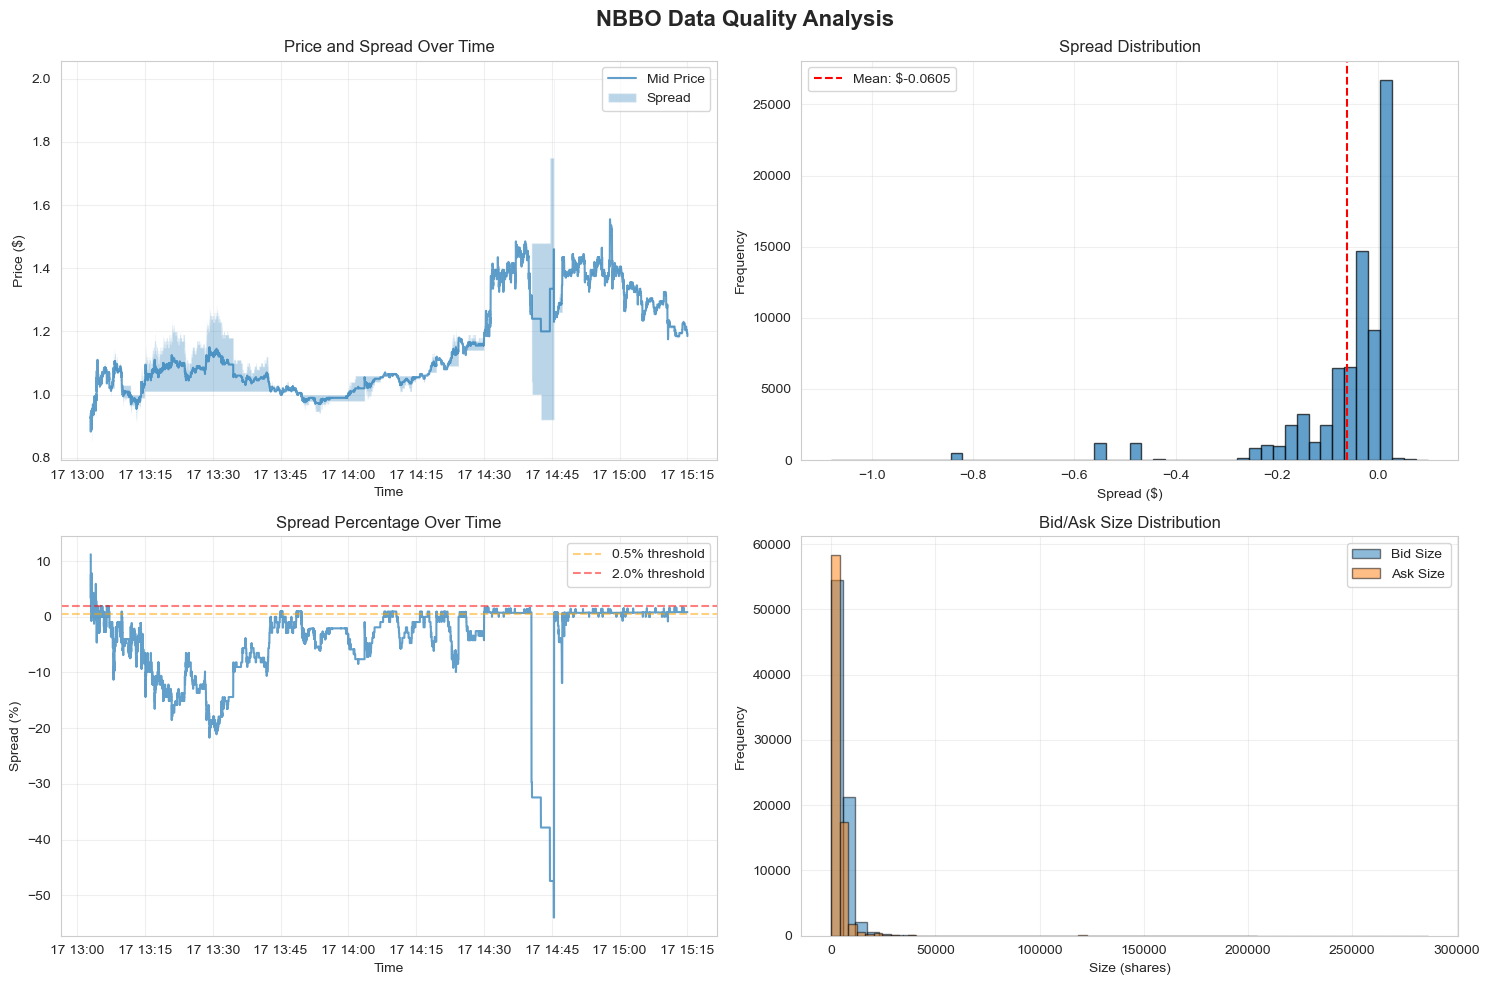

✅ Plots generated

PIPELINE COMPLETE
✅ Output file: ..\sessions\AMIX-20251117.bin.gz
✅ File size: 0.49 MB
✅ Samples: 79,195
⚠️  Quality: 1 issues detected


In [9]:
# Run the complete pipeline
output_file, metadata = process_session(
    symbol=SYMBOL,
    start_date=start_dt,
    end_date=end_dt,
    run_quality_checks=True,
    show_plots=True
)

In [10]:
# View metadata
print("\nSession Metadata:")
print("="*80)
for key, value in metadata.items():
    if key not in ['quality_results', 'publisher_map']:
        print(f"{key}: {value}")

print("\nPublisher Map:")
for pub_id, idx in sorted(metadata['publisher_map'].items()):
    print(f"  Publisher {pub_id}: index {idx}")


Session Metadata:
original_ticks: 571561
resampled_ticks: 79195
reduction_pct: 86.14408610804446
interval_ms: 100
publishers: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(43)]
start_time: 2025-11-17T13:03:00.248702327+00:00
end_time: 2025-11-17T15:14:59.659828198+00:00
output_file: ..\sessions\AMIX-20251117.bin.gz
num_samples: 79195
original_size_mb: 9.393304824829102
compressed_size_mb: 0.4923715591430664
compression_ratio: 19.077675487953453
compression_pct: 5.241728745367576

Publisher Map:
  Publisher 1: index 0
  Publisher 2: index 1
  Publisher 4: index 2
  Publisher 5: index 3
  Publisher 6: index 4
  Publisher 43: index 5


## 8. Cleanup

Remove temporary files after processing.

In [ ]:
# Cleanup temporary directory
if Config.TEMP_DIR.exists():
    shutil.rmtree(Config.TEMP_DIR)
    print(f"✅ Cleaned up temporary directory: {Config.TEMP_DIR}")
else:
    print("No temporary files to clean up")